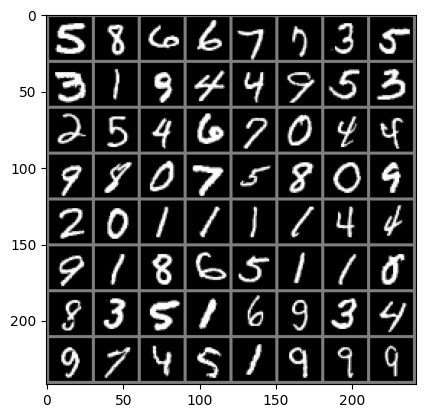

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define a transform to normalize the data (mean 0.5, deviation 0.5)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualize some images from the dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 1 input channel (grayscale), 16 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv layer + ReLU + Max Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second conv layer + ReLU + Max Pooling
        x = self.pool(F.relu(self.conv3(x)))  # Third conv layer + ReLU + Max Pooling
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 3 * 3)
        
        x = F.relu(self.fc1(x))  # First fully connected layer + ReLU
        x = self.fc2(x)          # Output layer
        
        return x

# Instantiate the model
cnn_net = CNN()

In [5]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = cnn_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 200] loss: 2.295
[Epoch 1, Batch 400] loss: 2.259
[Epoch 1, Batch 600] loss: 2.050
[Epoch 1, Batch 800] loss: 0.988
[Epoch 2, Batch 200] loss: 0.389
[Epoch 2, Batch 400] loss: 0.294
[Epoch 2, Batch 600] loss: 0.258
[Epoch 2, Batch 800] loss: 0.217
[Epoch 3, Batch 200] loss: 0.180
[Epoch 3, Batch 400] loss: 0.166
[Epoch 3, Batch 600] loss: 0.159
[Epoch 3, Batch 800] loss: 0.139
[Epoch 4, Batch 200] loss: 0.131
[Epoch 4, Batch 400] loss: 0.128
[Epoch 4, Batch 600] loss: 0.112
[Epoch 4, Batch 800] loss: 0.117
[Epoch 5, Batch 200] loss: 0.108
[Epoch 5, Batch 400] loss: 0.107
[Epoch 5, Batch 600] loss: 0.092
[Epoch 5, Batch 800] loss: 0.092
[Epoch 6, Batch 200] loss: 0.089
[Epoch 6, Batch 400] loss: 0.074
[Epoch 6, Batch 600] loss: 0.085
[Epoch 6, Batch 800] loss: 0.094
[Epoch 7, Batch 200] loss: 0.077
[Epoch 7, Batch 400] loss: 0.076
[Epoch 7, Batch 600] loss: 0.076
[Epoch 7, Batch 800] loss: 0.073
[Epoch 8, Batch 200] loss: 0.069
[Epoch 8, Batch 400] loss: 0.070
[Epoch 8, 

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10,000 test images: 98.31%


In [8]:
import tkinter as tk
from tkinter import Button
from PIL import Image, ImageDraw, ImageOps
import torch
import torchvision.transforms as transforms

# Define the drawing interface class
class DrawingApp:
    def __init__(self, root, model):
        self.root = root
        self.model = model
        self.root.title("Draw a digit")

        self.canvas = tk.Canvas(self.root, width=200, height=200, bg="white")
        self.canvas.pack()

        self.image1 = Image.new("L", (200, 200), 255)
        self.draw = ImageDraw.Draw(self.image1)

        self.canvas.bind("<B1-Motion>", self.paint)

        self.button_predict = Button(self.root, text="Predict", command=self.predict_digit)
        self.button_predict.pack()

        self.label_result = tk.Label(self.root, text="Draw a digit and click Predict")
        self.label_result.pack()

    def paint(self, event):
        # Draw lines on the canvas and on the image
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", width=15)
        self.draw.line([x1, y1, x2, y2], fill=0, width=15)

    def predict_digit(self):
        # Resize, invert and normalize the image
        image = self.image1.resize((28, 28))
        image = ImageOps.invert(image)
        image = image.convert("L")
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5,), (0.5,))(image)

        # Reshape image to fit the input requirements of the CNN
        image = image.view(1, 1, 28, 28)  # Add batch size and channel dimensions

        # Make the prediction
        output = self.model(image)
        _, predicted = torch.max(output.data, 1)
        self.label_result.config(text=f'Predicted: {predicted.item()}')

        # Clear the canvas for the next drawing
        self.canvas.delete("all")
        self.image1 = Image.new("L", (200, 200), 255)
        self.draw = ImageDraw.Draw(self.image1)

# Instantiate and run the GUI
def run_drawing_app(model):
    root = tk.Tk()
    app = DrawingApp(root, model)
    root.mainloop()

# Example usage
run_drawing_app(cnn_net)
